# 8. Pattern matching, local maxima

Sometimes threholding and binary operations are not appropriate tools to segment image features. This is particularly true when to object to be detected has as specific shape but a very variable intensity. In that case it is useful to attempt to build a "model" of the object and look for similar shapes in the image. It is very similar in essence to convolution, however the operation is normalized so that after filtering every pixel is assigned a value between -1 (anti-correlation) to +1 perfect correlation. One can then look for local matching maxima to identify objects.

In [1]:
from skimage.feature import match_template, peak_local_max

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.external.tifffile import TiffFile

import course_functions
datapath = course_functions.define_data_path()

In [3]:
#load the image to process
data = TiffFile(datapath+'Data/30567/30567_orig.tiff')
image = data.pages[3].asarray()

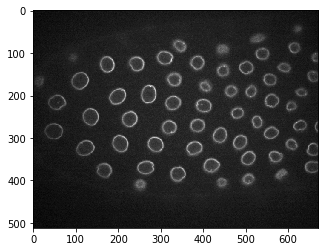

In [4]:
plt.imshow(image, cmap = 'gray')
plt.show()

## 8.1 Creating a template

From the image and our previous analysis, we can attempt to create a model of our objects as circles with a radius of 10 pixels. Let's first create a slightly larger image than the 20x20 image needed:

In [5]:
template = np.zeros((31,31))

Let's define the image center

In [6]:
center = [(template.shape[0]-1)/2,(template.shape[1]-1)/2]
center

[15.0, 15.0]

We create now two matrices: one contains the row index of each element, the other the column index:

In [7]:
Y, X = np.mgrid[0:template.shape[0],0:template.shape[1]]

In [8]:
X[7,10]

10

In [9]:
Y[7,10]

7

Using those indices, we can now create a new array that represents the Euclidian distancde of each pixel from the center:

In [10]:
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

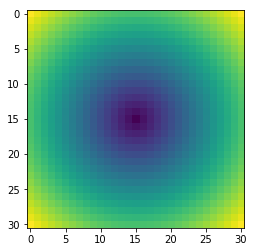

In [11]:
plt.imshow(dist_from_center)
plt.show()

And we can use these values in a logical operation. All pixels in the template within a 2 pixel band of the center are set to 1: 

In [12]:
radius = 13

template[(dist_from_center>=radius-1)&(dist_from_center<=radius+1)] = 1

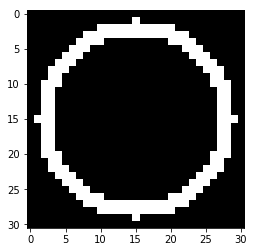

In [13]:
plt.imshow(template, cmap = 'gray')
plt.show()

## 8.2 Template matching

Now we can use the template matching function. We'll see later different options to handle borders.

In [14]:
matched = match_template(image=image, template=template)

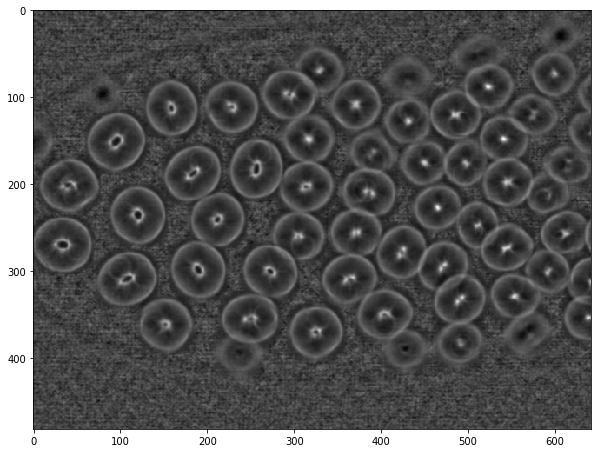

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(matched, cmap = 'gray')
plt.show()

We see that the result is not optimal, mainly because nuclei have quite different sizes. The consequence is that for larger nuclei we do not obtain a single maximum but a sort of ring (all positions where the template ring "touches" the nucleus boundary. Therefore template matching is not a good solutions here.

Let us look at another example.

## 8.3 Second example

In [16]:
import skimage.io as io

In [18]:
image = io.imread(datapath+'Data/A9/A9 p9d.tif')
#image = io.imread('/Users/gw18g940/Desktop/BBBC034_v1_dataset/AICS_12_134_C=1.tif')

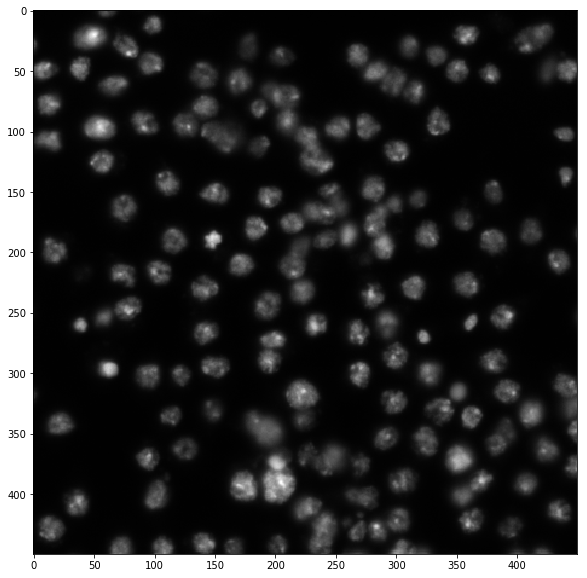

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
plt.show()

In this image, nuclei have radius of around 10 pixels. We can generate again a template:

In [20]:
radius = 10

template = np.zeros((25,25))
center = [(template.shape[0]-1)/2,(template.shape[1]-1)/2]
Y, X = np.mgrid[0:template.shape[0],0:template.shape[1]]
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
template[dist_from_center<=radius] = 1

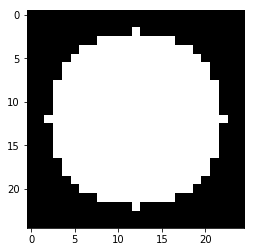

In [21]:
plt.imshow(template, cmap = 'gray')
plt.show()

In [22]:
matched = match_template(image=image, template=template)

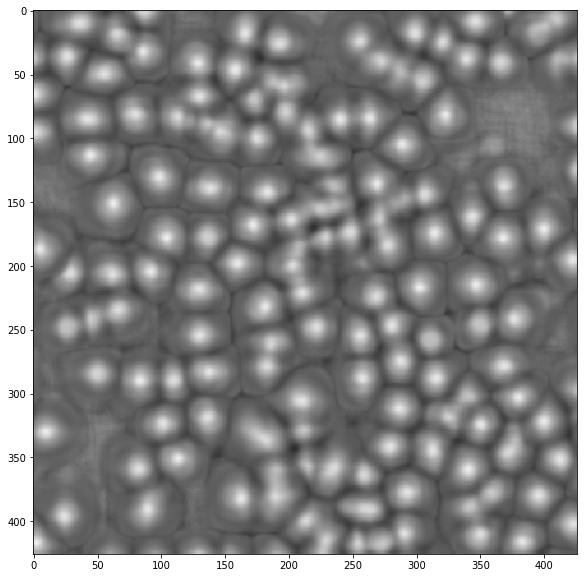

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(matched, cmap = 'gray', vmin = -1, vmax = 1)
plt.show()

We can now look for local maxima on that matching map. Without setting any constraints, wee might detect multiple very similar local maxima belonging to the same cell. To avoid that we can set a window size within which to select "true" local maxima. Also, the peak_local_max() function can return either the indices of peaks or another image.

In [24]:
local_max = peak_local_max(matched, min_distance=10,indices=False)
local_max_indices = peak_local_max(matched, min_distance=10,indices=True)

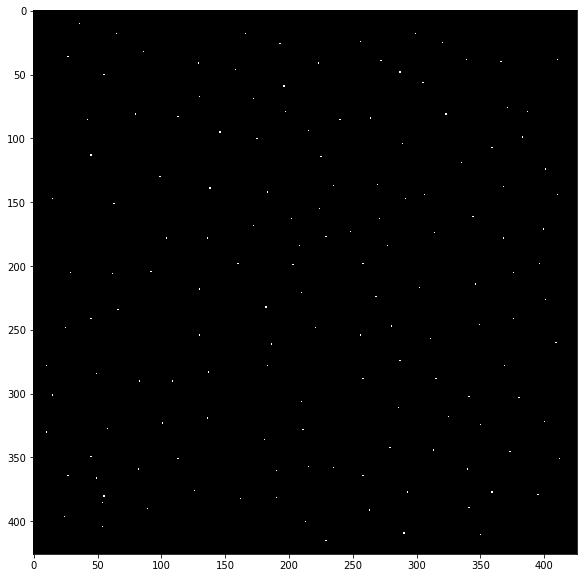

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(local_max, cmap = 'gray')
plt.show()

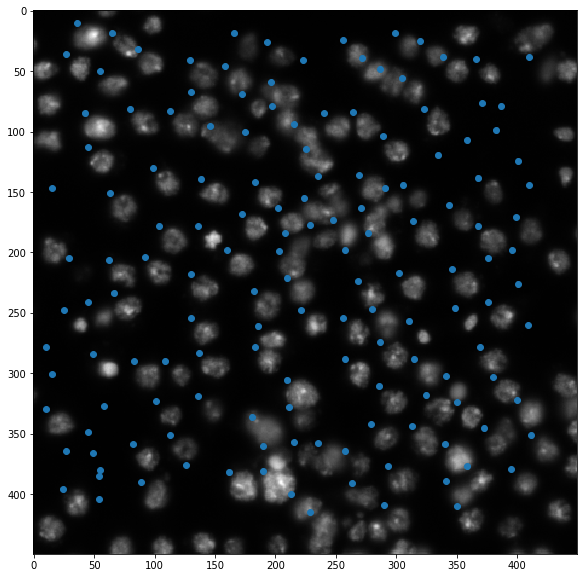

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
plt.plot(local_max_indices[:,1],local_max_indices[:,0],'o')
plt.show()

All detected nuclei look somehow shifted. Let's look in the match_template() help what might have gone wrong:

In [27]:
help(match_template)

Help on function match_template in module skimage.feature.template:

match_template(image, template, pad_input=False, mode='constant', constant_values=0)
    Match a template to a 2-D or 3-D image using normalized correlation.
    
    The output is an array with values between -1.0 and 1.0. The value at a
    given position corresponds to the correlation coefficient between the image
    and the template.
    
    For `pad_input=True` matches correspond to the center and otherwise to the
    top-left corner of the template. To find the best match you must search for
    peaks in the response (output) image.
    
    Parameters
    ----------
    image : (M, N[, D]) array
        2-D or 3-D input image.
    template : (m, n[, d]) array
        Template to locate. It must be `(m <= M, n <= N[, d <= D])`.
    pad_input : bool
        If True, pad `image` so that output is the same size as the image, and
        output values correspond to the template center. Otherwise, the output
      

When doing the template matching, the edges of the image get discarded by default. One can however pad the image, by adding rows and columns to recover a matched image of the same size:

In [28]:
matched = match_template(image=image, template=template, pad_input=True)

local_max = peak_local_max(matched, min_distance=10,indices=False)
local_max_indices = peak_local_max(matched, min_distance=10,indices=True)

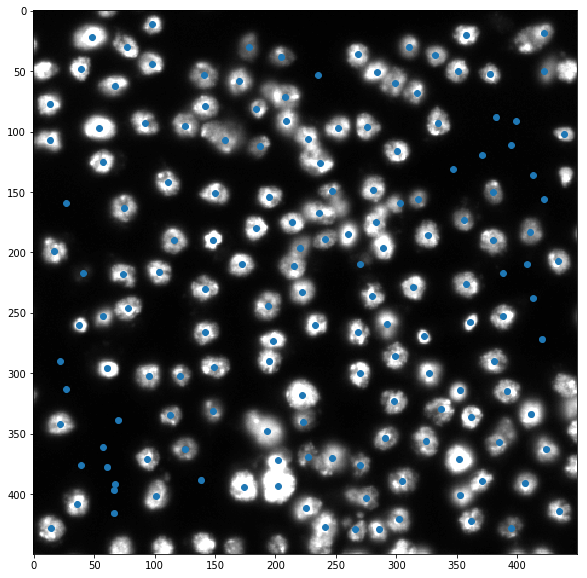

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray',vmax = 100)
plt.plot(local_max_indices[:,1],local_max_indices[:,0],'o')
plt.show()

We didn't set any threshold on what intensity local maxima should have, therefore we have a few detected cells that are clearly in the background. We could masks those using a rough threshold.

In [30]:
import skimage.filters
import skimage.morphology

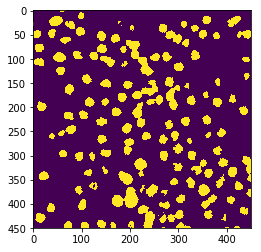

In [31]:
otsu = skimage.filters.threshold_otsu(image)

otsu_mask = image>otsu

plt.imshow(otsu_mask)
plt.show()

We can dilate a bit all the regions to make sure we fill the holes and do not cut off dim cells

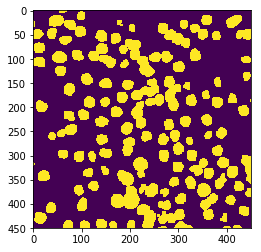

In [32]:
otsu_mask = skimage.morphology.binary_dilation(otsu_mask, np.ones((5,5)))
plt.imshow(otsu_mask)
plt.show()

Now we can mask the image returned by the peak finder:

In [33]:
masked_peaks = local_max*otsu_mask

And recover the coordinates of the detected peaks:

In [34]:
peak_coords = np.argwhere(masked_peaks)

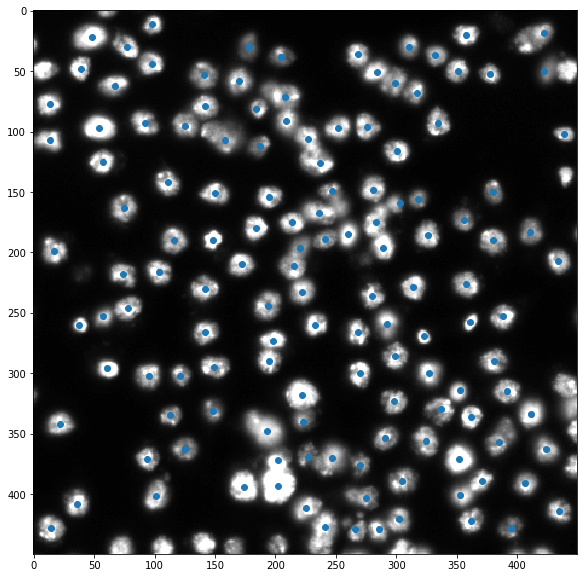

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray',vmax = 100)
plt.plot(peak_coords[:,1],peak_coords[:,0],'o')
plt.show()